In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import scipy
import urllib
import glob
import os
import pandas as pd
#import sncosmo
#import analyzeSN as ans
#import sndata as snd
##import sndata

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read photometry

#dat = Table.read('LSST_DDF_NONIa-0002_PHOT.FITS', format='fits')
dat = Table.read('LSST_WFD_NONIa-0011_PHOT.FITS.gz', format='fits')
df = dat.to_pandas()

#with fits.open('LSST_DDF_NONIa-0001_PHOT.FITS') as data:
#    df = pd.DataFrame(data[1].data)
    
#hdulist = fits.open('LSST_DDF_NONIa-0001_PHOT.FITS')

In [3]:
# Separate sources

indices = np.array(df.loc[df['MJD'] == -777].index)
indices = np.insert(indices,0,0,axis=0)
indices

array([     0,    149,    299, ..., 521252, 521386, 521520])

In [4]:
# Function to mask values with negative fluxes or those that do not pass the 5-sigma threshold

def mask(df, key, value):
    return df[df[key] == value]

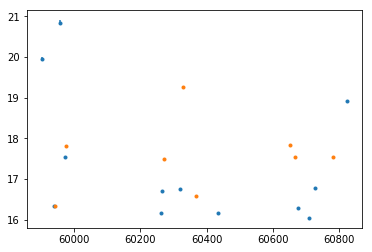

In [32]:
# Plot resulting lightcurves with values masked

i=16
df_new = df[indices[i]:indices[i+1]]
#df_new1 = df_new
df_new1 = mask(df_new,'PHOTFLAG',4096)
df_new1 = df_new1[df_new1.MAG != 128]
time = np.array(map(float,df_new1.ix[:,0].values))
mags = np.array(map(float,df_new1.ix[:,8].values))
dmags = np.array(map(float,df_new1.ix[:,9].values))
filters = np.array(df_new1.ix[:,1].values)
masks = [(filters == band+' ') for band in 'ri']
for band, masco in zip('ri', masks):
            plt.errorbar(time[masco], mags[masco], yerr=dmags[masco],fmt='.',label=band)
#print zip('ugrizY', masks)

Finding optimal frequency:
 - Estimated peak width = 0.00738
 - Using 5 steps per peak; omega_step = 0.00148
 - User-specified period range:  0.1 to 1
 - Computing periods at 38290 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
0.171051176719
Finding optimal frequency:
 - Estimated peak width = 0.00746
 - Using 5 steps per peak; omega_step = 0.00149
 - User-specified period range:  0.1 to 1
 - Computing periods at 37884 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
0.361001021468
Finding optimal frequency:
 - Estimated peak width = 0.00745
 - Using 5 steps per peak; omega_step = 0.00149
 - User-specified period range:  0.1 to 1
 - Computing periods at 37966 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
0.288098249678
Finding optimal frequency:
 - Estimated peak width = 0.00749
 - Using 5 steps per peak; omega_step = 0.0015
 - User-specified period range:  0.1 to 1
 - Computing periods at 37757 steps
Zoomi

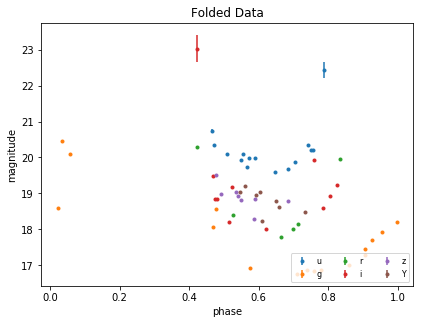

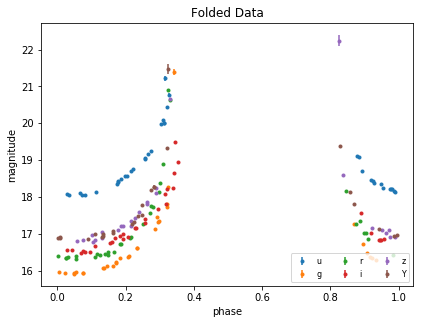

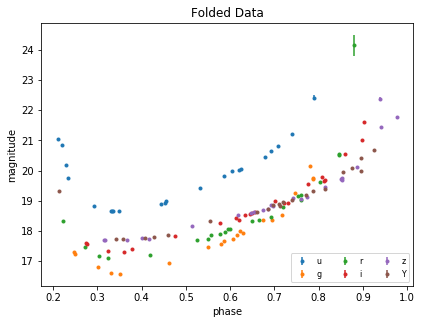

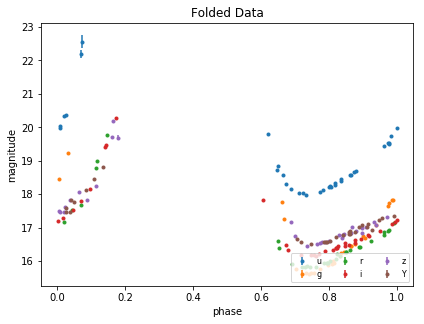

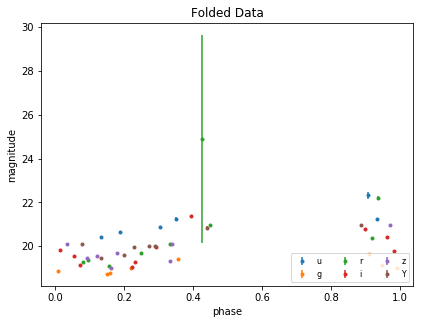

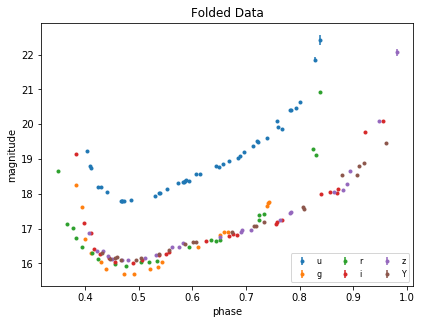

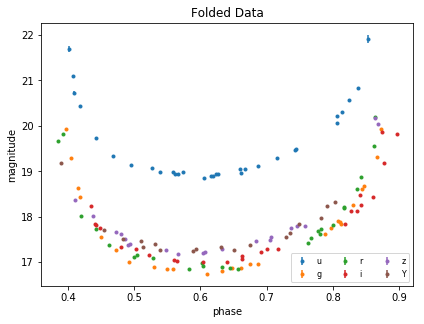

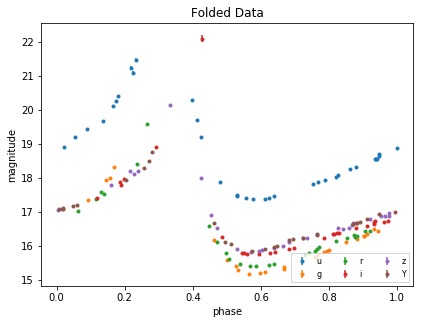

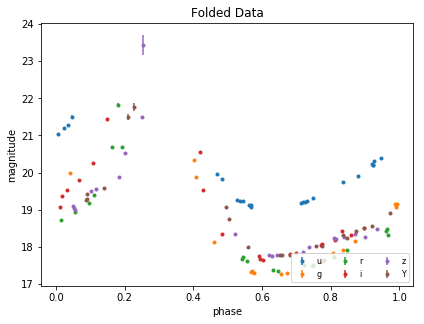

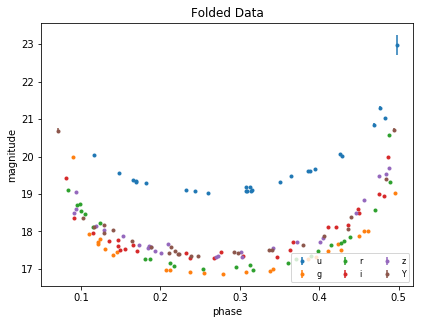

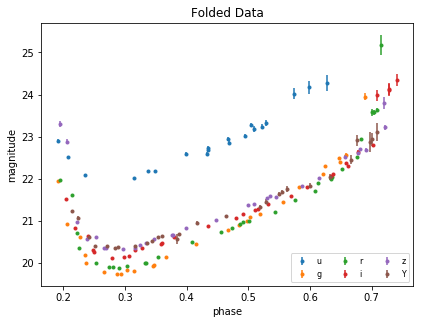

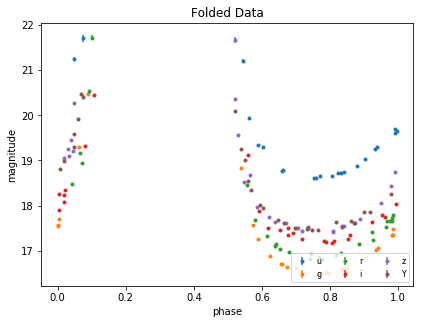

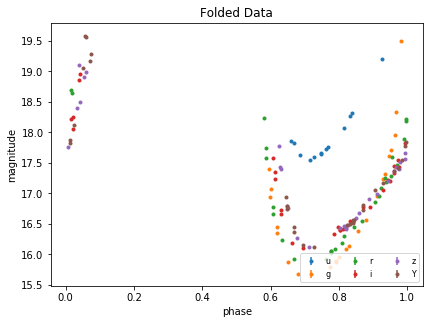

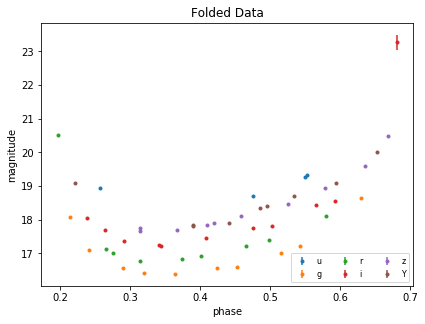

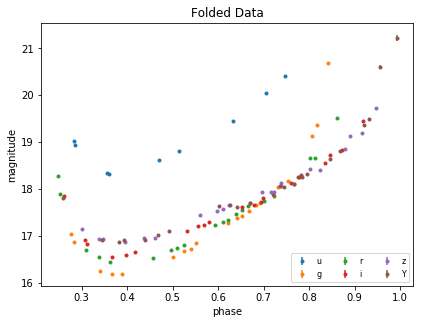

In [9]:
# This part uses the multi-band Lomb-Scargle periodogram to find periods.
# For a description of the algorithm see:
# http://www.astroml.org/gatspy/periodic/lomb_scargle_multiband.html
# This part also plots the folded light curve using the derived period.

from gatspy import periodic
periods = []
for i,index in enumerate(indices[0:15]):
    #if (i%100 == 0): print i
    if (index != 4904):
        df_new = df[index:indices[i+1]]
        # Include only detections above 5 sigma
        df_new1 = mask(df_new,'PHOTFLAG',4096)
        # Some magnitudes are still off the charts, I get rid of those
        df_new1 = df_new1[df_new1.MAG != 128]
        # Extract epochs, magnitudes, and filters
        time = np.array(map(float,df_new1.ix[:,0].values))
        mags = np.array(map(float,df_new1.ix[:,8].values))
        dmags = np.array(map(float,df_new1.ix[:,9].values))
        filters = np.array(df_new1.ix[:,1].values)
        masks = [(filters == band+' ') for band in 'ugrizY']
        # This is where I use the Multi-band Lomb Scargle periodogram to obtain periods
        ls = periodic.LombScargleMultiband(fit_period=True); #For finding periodicity in irregularly sampled data
        ls.optimizer.period_range = (0.1, 1.0);
        ls.fit(time,mags,dmags,filters);
        period = ls.best_period;
        periods.append(period)
        print (period)
        #Calculating the phase
        foldTimes = time/period
        foldTimes = foldTimes % 1
        foldTimes = np.array(foldTimes)
        
        #Plotting the folded light curves for each band
        fig = plt.figure(figsize=(14, 5))
        gs = plt.GridSpec(5, 2, left=0.10, right=0.95, bottom=0.15,
                          wspace=0.3, hspace=0.6)
        ax = [fig.add_subplot(gs[:, 0])]

        for band, masco in zip('ugrizY', masks):
            ax[0].errorbar(foldTimes[masco], mags[masco], yerr=dmags[masco],fmt='.',label=band)
        
        ax[0].legend(loc='lower right', fontsize=8, ncol=3)
        ax[0].set_title('Folded Data', fontsize=12)
        ax[0].set_xlabel('phase')
        ax[0].set_ylabel('magnitude')
        #plt.savefig('LC_'+str(i)+'_WFD_0001_folded.png',dpi=300,bbox_inches='tight')

#np.save('periods_WFD_0001.npy',periods)   

In [7]:
# FATS is a feature-finding algorithm for light curves. A description can be found here:
# http://isadoranun.github.io/tsfeat/FeaturesDocumentation.html
# Here we use fats to find features in the SNANAN light curves. We can use the derived features
# to compare statisticla properties with a real observed survey, such as SDSS Stripe 82.

import FATS

#import sys
#sys.path.append('/Users/jmartine/science/github/fats/FATS/FATS/')
##import *
#import Base
#from FeatureFunctionLib import *
#from Feature import *
#import PreprocessLC
#import alignLC
#import featureFunction
#import import_lc_cluster
#import import_lightcurve
#import lomb
#import test_library
#import time
##start = time.time()

df_collection = {}
feats_collection = {}

indocos = []

for i,index in enumerate(indices):
    if (i%100 == 0): print i
    if (index != 521520):
        df_new = df[index:indices[i+1]]
        # Include only detections above 5 sigma
        df_new1 = mask(df_new,'PHOTFLAG',4096)
        # Some magnitudes are still off the charts, I get rid of those
        df_new1 = df_new1[df_new1.MAG != 128]
        # Extract epochs, magnitudes, and filters
        time = np.array(map(float,df_new1.ix[:,0].values))
        mags = np.array(map(float,df_new1.ix[:,8].values))
        dmags = np.array(map(float,df_new1.ix[:,9].values))
        filters = np.array(df_new1.ix[:,1].values)
        #print filters
        #masks = [(filters == band+' ') for band in 'ugrizY']
        mags_g = mags[filters == 'g ']
        #print mags_g
        times_g = time[filters == 'g ']
        #print times_g
        dmags_g = dmags[filters == 'g ']
        mags_z = mags[filters == 'z ']
        times_z = time[filters == 'z ']
        dmags_z = dmags[filters == 'z ']
        if (len(mags_g) > 3):
            indocos.append(i)
            lc = np.array([mags_g, times_g, dmags_g, mags_z, times_z, dmags_z])
            # Here is where features are selected. You can select as many as you want from the FATS list
            a = FATS.FeatureSpace(Data=['magnitude','time','error','magnitude2','time2','error2'],
                         featureList=['Amplitude','PeriodLS','CAR_sigma','CAR_mean','CAR_tau',
                                      'Color','Autocor_length','LinearTrend','MaxSlope','Eta_e',
                                     'Freq1_harmonics_amplitude_0',
                                     'StetsonK','MedianBRP','Skew','SmallKurtosis'])
            a = a.calculateFeature(lc)
            feats_collection[i] = a.result(method='dict')
#indocos    
#end = time.time()
#print "time elapsed = ", (end - start)

0


/Users/jmartine/anaconda/lib/python2.7/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method powell cannot handle constraints nor bounds.
  RuntimeWarning)


100


/Users/jmartine/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700


In [8]:
# Save features
np.save('features_plasticc_WDF_0011.npy',feats_collection)
np.save('indocos_WDF_0011.npy',indocos)

In [2]:
# Load features
feats_collection = np.load('features_plasticc_WDF_0011.npy')
indocos = np.load('indocos_WDF_0011.npy')
d = dict(enumerate(feats_collection.flatten(), 1))

In [3]:
# Create numpy array of features (here you ca select which ones to use)
Y = []
#for i in range(len(d[1])):
for i in indocos:    
    #print 'AAAA',d[1][i]['Amplitude']
    Y.append([ np.log10(d[1][i]['Amplitude']),np.log10(d[1][i]['PeriodLS']),
              d[1][i]['CAR_sigma'], d[1][i]['CAR_mean'],d[1][i]['CAR_tau'],
              d[1][i]['Color'],d[1][i]['Autocor_length'], 
              d[1][i]['LinearTrend'], np.log10(d[1][i]['MaxSlope']),
              np.log10(d[1][i]['Eta_e']), np.log10(d[1][i]['Freq1_harmonics_amplitude_0']),
              np.log10(d[1][i]['StetsonK']), d[1][i]['MedianBRP'],d[1][i]['Skew'],
              d[1][i]['SmallKurtosis']])
Y = np.array(Y)
#obj_ids = numpy.arange(len(X))
ito = Y[:, 2]

[ -1.95967916  -1.83737317  -1.80030573 ...,  17.60411071  17.60646694
  17.60858156]


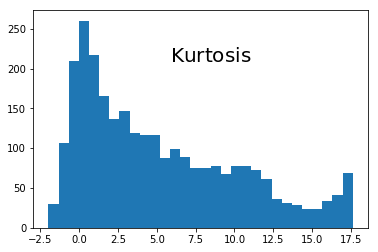

In [4]:
# Here you can plot the histograms of features for all light curves.

feat_names = [r"$\log\: \mathrm{Amplitude}$",r"$\log\: P_{LS}$",r"$\sigma_{\mathrm{CAR}}$",
              r"$\mu_{\mathrm{CAR}}$",r"$\tau_{\mathrm{CAR}}$",r"$\mathrm{Color}$",
              r"$\log\: \mathrm{ACL}$",r"$\mathrm{Linear Trend}$",r"$\log\: \mathrm{MaxSlope}$",
              r"$\log\: \eta_e$",r"$\log\: A_{10}$",r"$\log\: \mathrm{StetsonK}$",
              r"$\log\: \mathrm{MedianBRP}$",r"$\log\: \mathrm{Skew}$",r"$\mathrm{Kurtosis}$"]

#plt.hist(Y[:, 4][abs(Y[:, 4]) < 6.0 ])
Kurtosis = np.sort(Y[:, 14])
print Kurtosis
h = plt.hist(Kurtosis,bins=30)
#plt.xlim(-0.01,0.01)
plt.text(h[1][0]+(h[1][-1]-h[1][0])*0.4,0.8*max(h[0]),feat_names[14],size=20)#print np.min(Y[:, 5])
plt.savefig('Kurtosis_WDF.png',dpi=300,bbox_inches='tight')

[-1.39735062 -1.35374511 -1.27537674 ...,  0.63645297  0.63797923
  0.78796652]


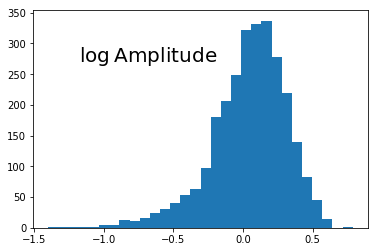

In [6]:
#plt.hist(Y[:, 4][abs(Y[:, 4]) < 6.0 ])
Amplitude = np.sort(Y[:, 0])
print Amplitude
h = plt.hist(Amplitude,bins=30)
#plt.xlim(-0.01,0.01)
plt.text(h[1][0]+(h[1][-1]-h[1][0])*0.1,0.8*max(h[0]),feat_names[0],size=20)#print np.min(Y[:, 5])
plt.savefig('Amplitude_WDF.png',dpi=300,bbox_inches='tight')